In [3]:
use_multi_gpu = True 
import os

if  use_multi_gpu == True:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # The GPU id to use, usually either "0" or "1";
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 3";
if  use_multi_gpu == False:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # The GPU id to use, usually either "0" or "1";
    os.environ["CUDA_VISIBLE_DEVICES"] = "1";
import tensorflow as tf
tf_version = tf.__version__
if tf_version == '1.13.1' or tf_version == '1.15.0':
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    #config.log_device_placement = True  
    sess = tf.Session(config=config)
elif tf_version == '2.0.0':
    tf.compat.v1.disable_eager_execution()
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for gpus in physical_devices:
      tf.config.experimental.set_memory_growth(gpus, True)
      
elif tf_version == '2.2.0' or tf.__version__ == '2.2.0-rc2':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for gpus in physical_devices:
      tf.config.experimental.set_memory_growth(gpus, True)
      
from data_writers import show_results, draw_boxes, write_xml, yolotensor2xml
from data_processors import nms_v1, nms_v2, convert_xml2txt

import numpy as np
import matplotlib.pyplot as plt
import cv2, glob
import math, random
from YOLO_DataGenerator import make_data_list, My_Custom_Generator, make_yolo_tensor
#from preprocessors import show_results, NMS, draw_boxes, nms_v2
#from postprocessor import yolotensor2xml, write_xml
from evaluation import calculate_mAP, ConfusionMatrix, plot_confusion_matrix, read_txt, process
from model import yolo, yolo_exception, yolo_loss, yolo_mine, yolo_mobilenet_v2, yolo_exception_mod
from losses import YOLO_LOSS, YOLO_LOSS_Updated
from tqdm import tqdm, trange
from callbacks import PlotLearning, SGDRScheduler, CustomLearningRateScheduler, PredictionCallback
import tensorflow as tf
if tf.__version__ == '2.0.0' or tf.__version__ == '2.2.0' or tf.__version__ == '2.2.0-rc2':
   from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback, TensorBoard
   from tensorflow.keras.layers import Input, Conv2D, Dense, SeparableConv2D
   from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

if tf.__version__ == '1.15.0' or tf.__version__ == '1.13.1':
    from keras.models import Model
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback
    from keras.layers import Input, Conv2D, Dense, SeparableConv2D
    from keras.optimizers import Adam, Nadam, SGD

#%
###########################################
#         Define Variable
###########################################
read_from_directory_train = '/home/user01/data_ssd/Talha/yolo_data/pascal_voc/train/'
read_from_directory_val = '/home/user01/data_ssd/Talha/yolo_data/pascal_voc/valid/'
grid_size = 13
modelip_img_w = 448
modelip_img_h = 448
num_class = 20
batch_size = 8
input_ch = 3 
boxes_percell = 2
dropout_rate = 0.5
Epochs = 150
w_decay_value = 0.0005
initial_lr = 0.0002
lr_decay = 0.95 #
drop_epoch = 30 #step decay
power = 0.9 # for polynomial decay
lr_schedule = 'polynomial_decay'  # polynomial_decay  -or- step_decay -or- K_decay -or- SGDR_lr -or- yolo_decay

classes_name = []
with open(read_from_directory_train + '_classes.txt', 'r') as f:
        classes_name = classes_name + f.readlines()
for i in range(len(classes_name)):
    classes_name[i] = classes_name[i].strip()
###########################################
#         Start Data Generator
###########################################
X_train, Y_train = make_data_list(read_from_directory_train)
X_val, Y_val = make_data_list(read_from_directory_val)
train_data_gen = My_Custom_Generator(X_train, Y_train, batch_size, modelip_img_w, modelip_img_h,
                                     grid_size, num_class)
val_data_gen = My_Custom_Generator(X_val, Y_val, batch_size, modelip_img_w, modelip_img_h,
                                   grid_size, num_class)
#%
x_train, y_train = train_data_gen.__getitem__(30)
x_val, y_val = val_data_gen.__getitem__(30)
print('='*60)
print('Train Batch (images)      :', x_train.shape)
print('Train Labels (yolo_tenosr):',y_train.shape)
print('Val Batch (images)        :',x_val.shape)
print('Val Labels (yolo_tenosr)  :',y_val.shape)
print('='*60)
# test images
op = show_results(x_train[0, ...], y_train[0, ...], classes_name, modelip_img_w, modelip_img_h, from_nms=False)
plt.imshow(op)
plt.title('Data_gen_Test_img')
#%
###########################################
#         Define Model
###########################################
input_img = Input((modelip_img_h, modelip_img_w,  input_ch), name='ip')
input_shape = (modelip_img_h, modelip_img_w, input_ch)
#   yolo_mobilenet_v2    yolo_exception   yolo_exception_mod
#model = yolo(input_img, grid_size, boxes_percell, num_class, dropout_rate, batchnorm = True, Alpha = 0.1)
model = yolo_exception(input_shape, grid_size, boxes_percell, num_class, dropout = dropout_rate, Alpha = 0.1, batchnorm = True)
for layer in model.layers:
        if isinstance(layer, Conv2D) or isinstance(layer, Dense):
            layer.kernel_regularizer = tf.keras.regularizers.l2(l=w_decay_value)
        elif isinstance(layer, SeparableConv2D):
            layer.depthwise_regularizer = tf.keras.regularizers.l2(l=w_decay_value/2)
            layer.pointwise_regularizer = tf.keras.regularizers.l2(l=w_decay_value/4)
        elif hasattr(layer, 'bias_regularizer') and layer.use_bias:
            layer.bias_regularizer =  tf.keras.regularizers.l2(l=w_decay_value)
            
#model.summary()           # momentum=0.9              # YOLO_LOSS_Updated    YOLO_LOSS
model.compile(optimizer=Adam(), loss = YOLO_LOSS, metrics = ['accuracy']) 
###########################################
#         Define Callbacks
###########################################
plot_losses = PlotLearning()
if lr_schedule == 'SGDR_lr' :
    LR_schedule = SGDRScheduler(min_lr=1e-7,max_lr=initial_lr, steps_per_epoch=int(len(X_train) // batch_size),
                                lr_decay=lr_decay,cycle_length=20,mult_factor=2)
else:
    LR_schedule = CustomLearningRateScheduler(lr_schedule, initial_lr, lr_decay, Epochs, drop_epoch, power)
show_pred = PredictionCallback(X_val, Y_val, modelip_img_h, modelip_img_w, classes_name, grid_size, num_class, boxes_percell)
callbacks = [
    LR_schedule, plot_losses, show_pred
            ]  

Train Batch (images)      : (8, 448, 448, 3)
Train Labels (yolo_tenosr): (8, 13, 13, 25)
Val Batch (images)        : (8, 448, 448, 3)
Val Labels (yolo_tenosr)  : (8, 13, 13, 25)


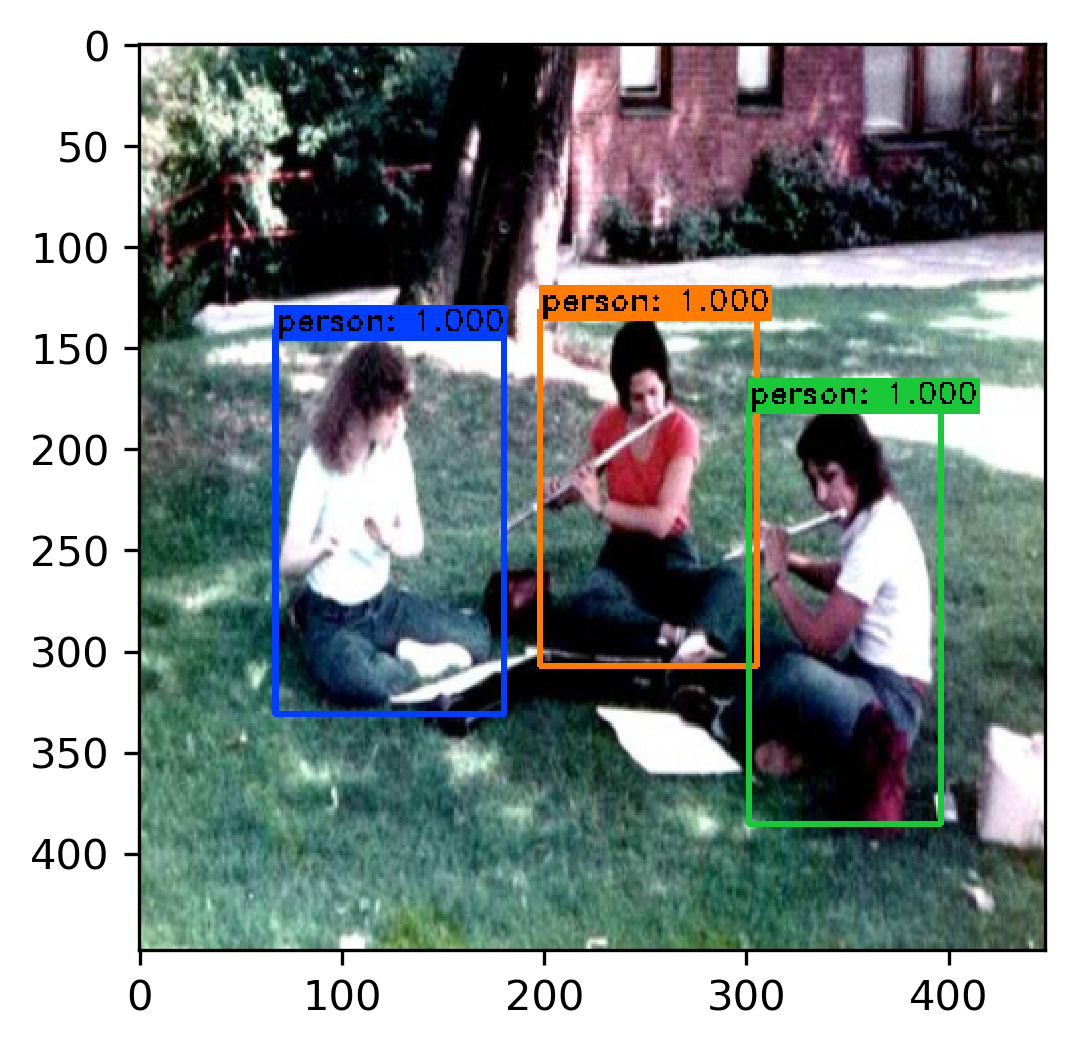

In [42]:
##################################################################################################
# check annontation files and read according index frm the list
# just for sanity chech that data generator is working properly
# read the README.md file of repo for details
##################################################################################################
i = np.random.randint(0,len(X_train))
orig_img, orig_op = make_yolo_tensor(X_train[i], Y_train[i], modelip_img_w, modelip_img_h, grid_size, num_class)
op = show_results(orig_img, orig_op, classes_name, modelip_img_w, modelip_img_h, from_nms=False)
plt.imshow(orig_img)

In [ ]:
model.fit(x=train_data_gen, steps_per_epoch = int(len(X_train) // batch_size), epochs = Epochs,
          initial_epoch=0,validation_data = val_data_gen, 
          validation_steps = int(len(X_val) // batch_size), callbacks=callbacks)
# I have already trained the model so i'll just load the weights

In [45]:
model.load_weights("/home/user01/data_ssd/Talha/yolo_data/pascal_13_448.h5")

In [126]:
#############################################################################
#             Test Model and Plot preds after NMS
# read README.md for details on nms_v1 and nms_v2
#############################################################################
# For NMS
from nms_test import NMS_Test
import copy
import time

eval_set = X_train
eval_label = Y_train
i = np.random.randint(0,len(eval_set))
#%
img = cv2.imread(eval_set[i])
img = cv2.resize(img, (modelip_img_w, modelip_img_h))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

iou_thresh = 0.3
confd_thersh = 0.3
pred = model.predict(img[np.newaxis,:,:,:]/255, verbose=1, use_multiprocessing=False)#Normalizing
pred = pred.squeeze()
p1 = copy.deepcopy(pred)
p2 = copy.deepcopy(pred)

# NMS v1
s = time.time()
nms_pred = nms_v1(p1, iou_thresh, confd_thersh, grid_size, num_class, boxes_percell, modelip_img_w, modelip_img_h)
op2 = show_results(img/255, nms_pred, classes_name, modelip_img_w, modelip_img_h)
e1= time.time()
# NMS v2
nms_boxes, nms_scores, nms_classes_names, _ = nms_v2(p2, iou_thresh, confd_thersh, grid_size, num_class, classes_name, boxes_percell, modelip_img_w, modelip_img_h, use_numpy=True)
op = draw_boxes(img/255, nms_scores, nms_boxes, nms_classes_names, classes_name)
e2 = time.time()

# plottign GT side by side wiht preds
orig_img, orig_op = make_yolo_tensor(eval_set[i], eval_label[i], modelip_img_w, modelip_img_h, grid_size, num_class)
op0 = show_results(orig_img, orig_op, classes_name, modelip_img_w, modelip_img_h, from_nms=False)

print('Time taken for NMS_v1',np.round(e1-s, 4), 'seconds')
print('Time taken for NMS_v2', np.round(e2-e1, 4), 'seconds')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4), sharex=False)
ax1.imshow(op0)
ax1.axis("off")
ax1.set_title('GT')
ax2.imshow(op)
ax2.axis("off")
ax2.set_title('Pred_v2')
ax3.imshow(op2)
ax3.axis("off")
ax3.set_title('Pred_v1')

1/1 [==============================] - 0s 26ms/sample
Time taken for NMS_v1 0.098 seconds
Time taken for NMS_v2 0.0071 seconds


Text(0.5, 1.0, 'Pred_v1')

In [52]:
#############################################################################
#      Measure the mAP of your trained model
# read README.md for details 
#############################################################################
# save the predicted xml files in this directory
op_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/yolo_pred/'
# deleting files in op_dir
filelist = [ f for f in os.listdir(op_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from Pred directory'):
    os.remove(os.path.join(op_dir, f))

#%
iou_thresh = 0.3
confd_thersh1 = 0.4
confd_thersh2 = 0.3
a = 0 # counters for exception handels
b = 0

eval_set = X_val

for i in trange(len(eval_set), desc = 'Evaluating and saving to Pred directory'):
    n = eval_set[i]
    
    img = cv2.imread(n)
    img = cv2.resize(img, (modelip_img_w, modelip_img_h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    pred = model.predict(img[np.newaxis,:,:,:]/255, verbose=0)#Normalizing
    pred = pred.squeeze()
    try:
        nms_pred = nms_v1(pred, iou_thresh, confd_thersh1, grid_size, num_class, boxes_percell, modelip_img_w, modelip_img_h)
        op2 = show_results(img, nms_pred, classes_name, modelip_img_w, modelip_img_h)
        yolotensor2xml(eval_set[i], nms_pred, grid_size, classes_name, num_class, op_dir) 
        
        # nms_boxes, nms_scores, nms_classes_names, nms_box_norm = nms_v2(pred, iou_thresh, confd_thersh1, grid_size, num_class, 
        #                                                   classes_name, boxes_percell, modelip_img_w, modelip_img_h, use_numpy=True)
        # file_name = os.path.basename(eval_set[i])[:-4]
        # op = draw_boxes(img, nms_scores, nms_boxes, nms_classes_names, classes_name)
        # write_xml(eval_set[i], nms_scores, nms_box_norm, nms_classes_names, op_dir)
    except (UnboundLocalError or ValueError):
        try:
            nms_pred = nms_v1(pred, iou_thresh, confd_thersh2, grid_size, num_class, boxes_percell, modelip_img_w, modelip_img_h)
            op2 = show_results(img, nms_pred, classes_name, modelip_img_w, modelip_img_h)
            yolotensor2xml(eval_set[i], nms_pred, grid_size, classes_name, num_class, op_dir) 
            
 
            # nms_boxes, nms_scores, nms_classes_names, nms_box_norm = nms_v2(pred, iou_thresh, confd_thersh2, grid_size, num_class,
            #                                                   classes_name, boxes_percell, modelip_img_w, modelip_img_h, use_numpy=True)
            # file_name = os.path.basename(eval_set[i])[:-4]
            # op = draw_boxes(img, nms_scores, nms_boxes, nms_classes_names, classes_name)
            # write_xml(eval_set[i], nms_scores, nms_box_norm, nms_classes_names, op_dir)
        except (UnboundLocalError or ValueError):
            a+=1
    except:
        pass#print("Overflow Error")
        b+=1
#%
import shutil, os
import glob
gt_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/yolo_gt/'
# deleting files in gt_dir
filelist = [ f for f in os.listdir(gt_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from GT directory'):
    os.remove(os.path.join(gt_dir, f))

#%
# read files from this dir and only copy the files which were predicted correctly
# by NETWORK       Annotations_XML    annotations_xml_processed    rice_xml   paparika_xml  bccd_xml
copy_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/annotations_xml_processed/'
# only copy the files on which network gave some predictions
# i.e. the files in op_dir 
filelist = [ f for f in os.listdir(op_dir)]
for f in tqdm(filelist, desc = 'Copying files to GT directory'):
    file = copy_dir + f
    shutil.copy(file, gt_dir)
    
print('Files in GT Directory:', len(glob.glob(os.path.join(gt_dir, '*.xml'))))
print('Files in Pred Directory:', len(glob.glob(os.path.join(op_dir, '*.xml'))))
#%

classes = classes_name
IoUThreshold = 0.3
calculate_mAP(gt_dir, op_dir, num_class, classes_name, IoUThreshold)

Copying files to GT directory: 100%|██████████| 2622/2622 [00:00<00:00, 4062.84it/s]


Files in GT Directory: 2622
Files in Pred Directory: 2622
| Class_Name   |   Total GT |   Total Pred. |   TP |   FP |   FN |       AP |
|--------------|------------|---------------|------|------|------|----------|
| aeroplane    |        216 |           153 |  135 |   18 |   81 | 0.619045 |
| bicycle      |        149 |            45 |   43 |    2 |  106 | 0.270613 |
| bird         |        219 |           138 |  113 |   25 |  106 | 0.509256 |
| boat         |        113 |            46 |   25 |   21 |   88 | 0.207459 |
| bottle       |        174 |            28 |   22 |    6 |  152 | 0.170455 |
| bus          |        109 |            54 |   52 |    2 |   57 | 0.447046 |
| car          |        405 |           168 |  123 |   45 |  282 | 0.319196 |
| cat          |        207 |           197 |  176 |   21 |   31 | 0.784733 |
| chair        |        298 |            48 |   41 |    7 |  257 | 0.173554 |
| cow          |         71 |            47 |   32 |   15 |   39 | 0.385995 |
| dini

In [10]:
#############################################################################
#      Plot confusion matrix of the model
# read README.md for details 
#############################################################################
# First cionvert op xml files to txt files 
gt_xml_filepaths = gt_dir
pred_xml_filepaths = op_dir

gt_op_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/gt_txt/'
# deleting files in gt_dir
filelist = [ f for f in os.listdir(gt_op_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from GT directory'):
    os.remove(os.path.join(gt_op_dir, f))
pred_op_dir = '/home/user01/data_ssd/Talha/yolo_data/eval/pred_txt/'
# deleting files in gt_dir
filelist = [ f for f in os.listdir(pred_op_dir)]# if f.endswith(".png") ]
for f in tqdm(filelist, desc = 'Deleting old files from Pred directory'):
    os.remove(os.path.join(pred_op_dir, f))
# covnert
convert_xml2txt(gt_xml_filepaths, gt_op_dir, gt=True)
convert_xml2txt(pred_xml_filepaths, pred_op_dir, gt=False)

class_names = ['aeroplane', 'bicycle', 'bird','boat','bottle', 'bus', 'car',
                'cat', 'chair', 'cow','diningtable','dog', 'horse', 'motorbike',
                'person','pottedplant','sheep', 'sofa', 'train', 'tvmonitor']


gt = glob.glob(os.path.join(gt_op_dir,'*.txt'))
pred = glob.glob(os.path.join(pred_op_dir,'*.txt'))
conf_mat = ConfusionMatrix(num_classes = len(class_names), CONF_THRESHOLD = 0.3, IOU_THRESHOLD = 0.5)

for i in range(len(gt)):
    y_t = np.asarray(read_txt(gt[i], pred=False))
    y_p = np.asarray(read_txt(pred[i], pred=True))
    
    if y_p.size !=0:
        
        y_t = process(y_t, class_names)
        y_p = process(y_p, class_names, gt = False)
        
        conf_mat.process_batch(y_p, y_t) 
        
cm = conf_mat.matrix


c_m = plot_confusion_matrix(cm, class_names, normalize = True, show_text = False, show_fpfn = True)

Converting: 100%|██████████| 2622/2622 [00:00<00:00, 6707.82it/s]


********************************************************************************
NOTE: In confusion_matrix the last coloumn "FP/FN" shows False Positives in Groundtruths           
and False Negatives in Predictions
********************************************************************************


********************************************************************************
NOTE: In confusion_matrix the last coloumn "FP/FN" shows False Positives in Groundtruths           
and False Negatives in Predictions
********************************************************************************


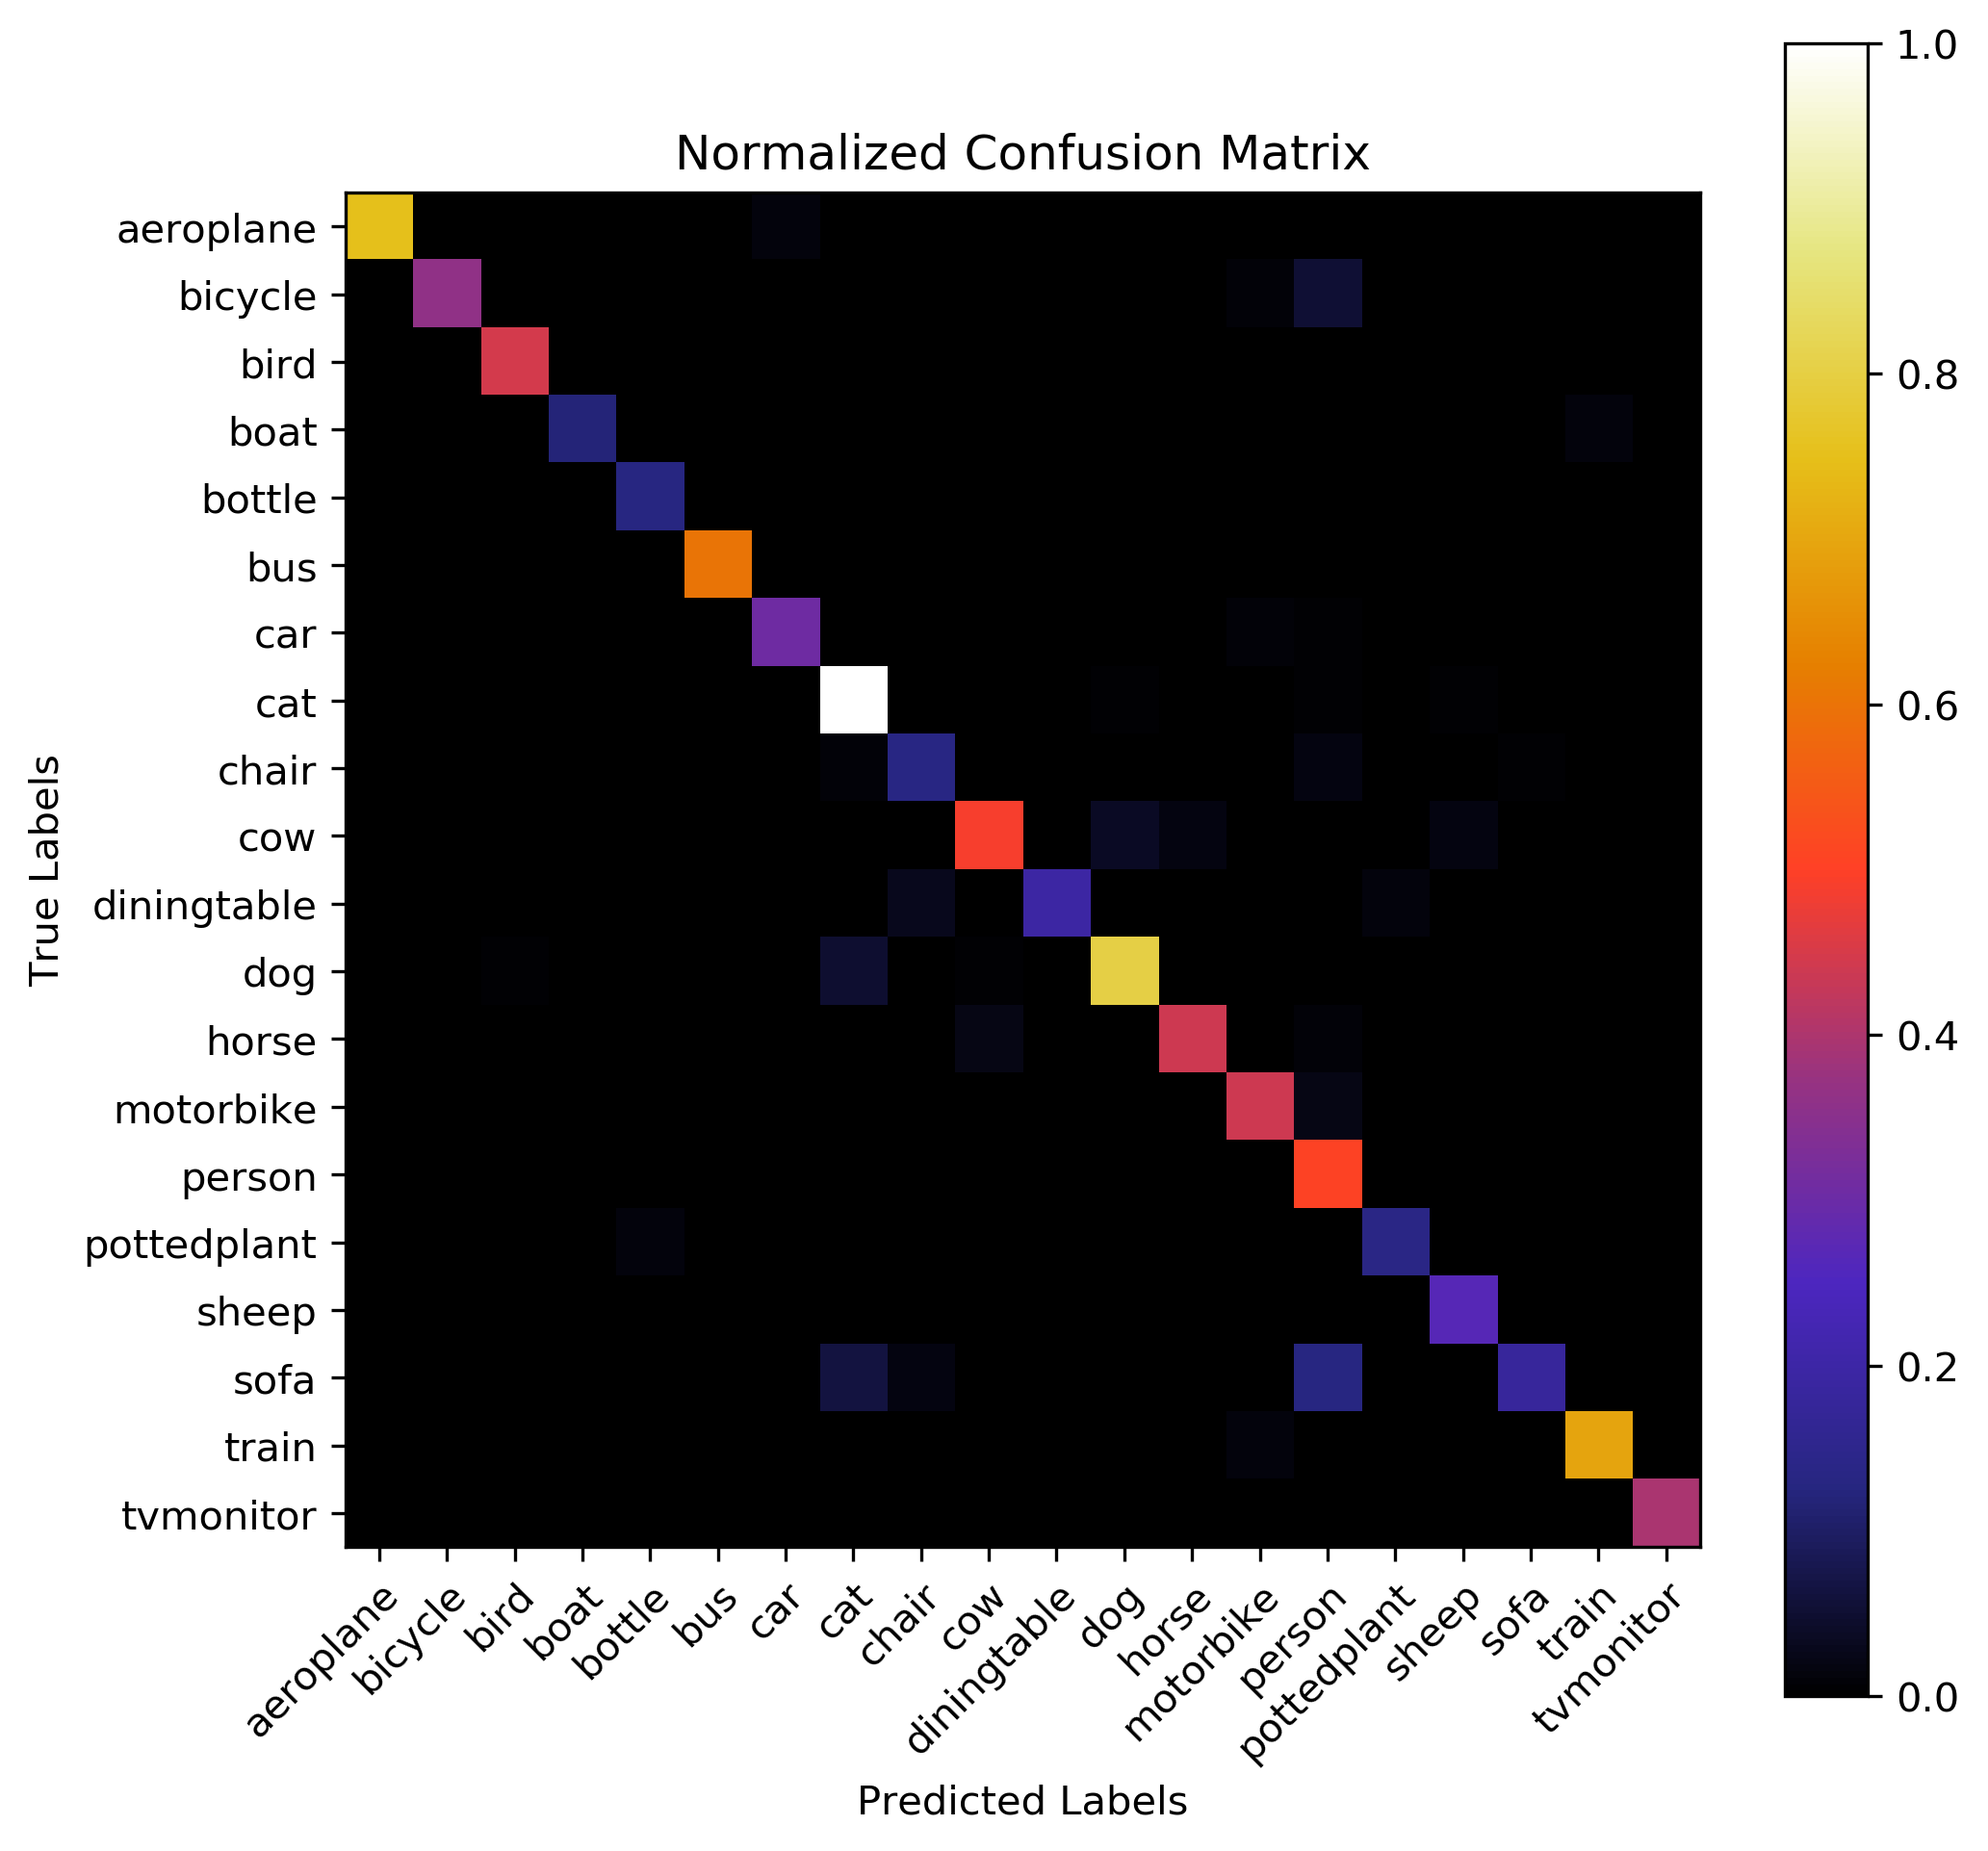

In [12]:
# if we don't count FP/FN then it looks good ;) 
c_m = plot_confusion_matrix(cm, class_names, normalize = True, show_text = False, show_fpfn = False)